# Marketing Bancario

## Objetivo

Contamos con informacion de una institucion bancaria Portugesa, y se tiene el objetivo de predecir si un cliente va a suscribirse a un deposito a plazo. ( la variable objetivo )

## Librerias utilizadas

In [33]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif


from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier, plot_importance
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


### Parametros

In [3]:
RANDOM_STATE = 3

## Carga de los datos

In [4]:
df = pd.read_csv('../datasets/raw/bank.csv', sep=';')

print(df.shape)
df.head(2)

(4521, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no


## Funciones

In [23]:
def make_mi_scores(x, y):
    """ Calcula el indicador MI para cada característica int. """

    x = x.copy()
    for colname in x.select_dtypes(["object", "category"]):
        x[colname], _ = x[colname].factorize()

    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in x.dtypes]
    
    mi_scores = mutual_info_classif(x, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)

## Descripcion de los datos

### Sobre la distribucion

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


In [6]:
def describe(df):
    return pd.concat([df.describe().T,
                      df.skew().rename('skew'),
                      df.kurt().rename('kurt'),
                     ], axis=1).T

describe(df.select_dtypes(include=['int64']))

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000
skew,0.699501,6.596431,0.094627,2.772420,4.743914,2.717071,5.875259
kurt,0.348775,88.390332,-1.039531,12.530050,37.168920,7.957128,51.995212


In [7]:
df.describe(include='O')

,job,marital,education,default,housing,loan,contact,month,poutcome,y
count,4521,4521,4521,4521,4521,4521,4521,4521,4521,4521
unique,12,3,4,2,2,2,3,12,4,2
top,management,married,secondary,no,yes,no,cellular,may,unknown,no
freq,969,2797,2306,4445,2559,3830,2896,1398,3705,4000


In [8]:
df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [9]:
df.nunique()

age            67
job            12
marital         3
education       4
default         2
balance      2353
housing         2
loan            2
contact         3
day            31
month          12
duration      875
campaign       32
pdays         292
previous       24
poutcome        4
y               2
dtype: int64

#### comentarios

Con base en los datos previos, ninguna de las caracteristicas estan distribuidas normalmente

---

### Sobre valores ausentes

In [10]:
### 
df_missings = df.copy().select_dtypes(include=['object'])
df_missings = df_missings.replace('unknown', np.nan)

df_missings.isna().mean() * 100


job           0.840522
marital       0.000000
education     4.136253
default       0.000000
housing       0.000000
loan          0.000000
contact      29.285556
month         0.000000
poutcome     81.950896
y             0.000000
dtype: float64

#### comentarios
Basado en el analisis previo, en las variables categoricas hay omisiones marcadas como 'unknown'. El analisis mostró algunos porcentajes en los datos.

Podemos ver que para las variables de contacto (29%) y sobre la variable poutcome (82%) respectivamente.



## Preprocesamiento

Se considera pertinente eliminar las filas con valores ausentes debido a los siguientes aspectos:

- Se está trabajando con el dataset completo por lo que eliminar filas con valores ausentes aumentaria la calidad de la muestra
- En el futuro de cualquier forma no se podrían predecir de forma correcta el resultado debido a estos valores.
- Los datos no se encuentran balanceados.

In [ ]:
# df_temp = df.dropna(subset=['job', 'education', 'contact', 'poutcome'])
df_temp = df.dropna()

df_temp.shape

(4521, 17)

In [13]:
num_cols = [x for x in df.columns if df[x].dtype != 'object']
cat_cols = [x for x in df.columns if df[x].dtype == 'object']

print(num_cols)
print(cat_cols)

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']


Gracias al siguiente grafico se puede observar que ninguna de las caracteristicas tiene una relacion lineal.

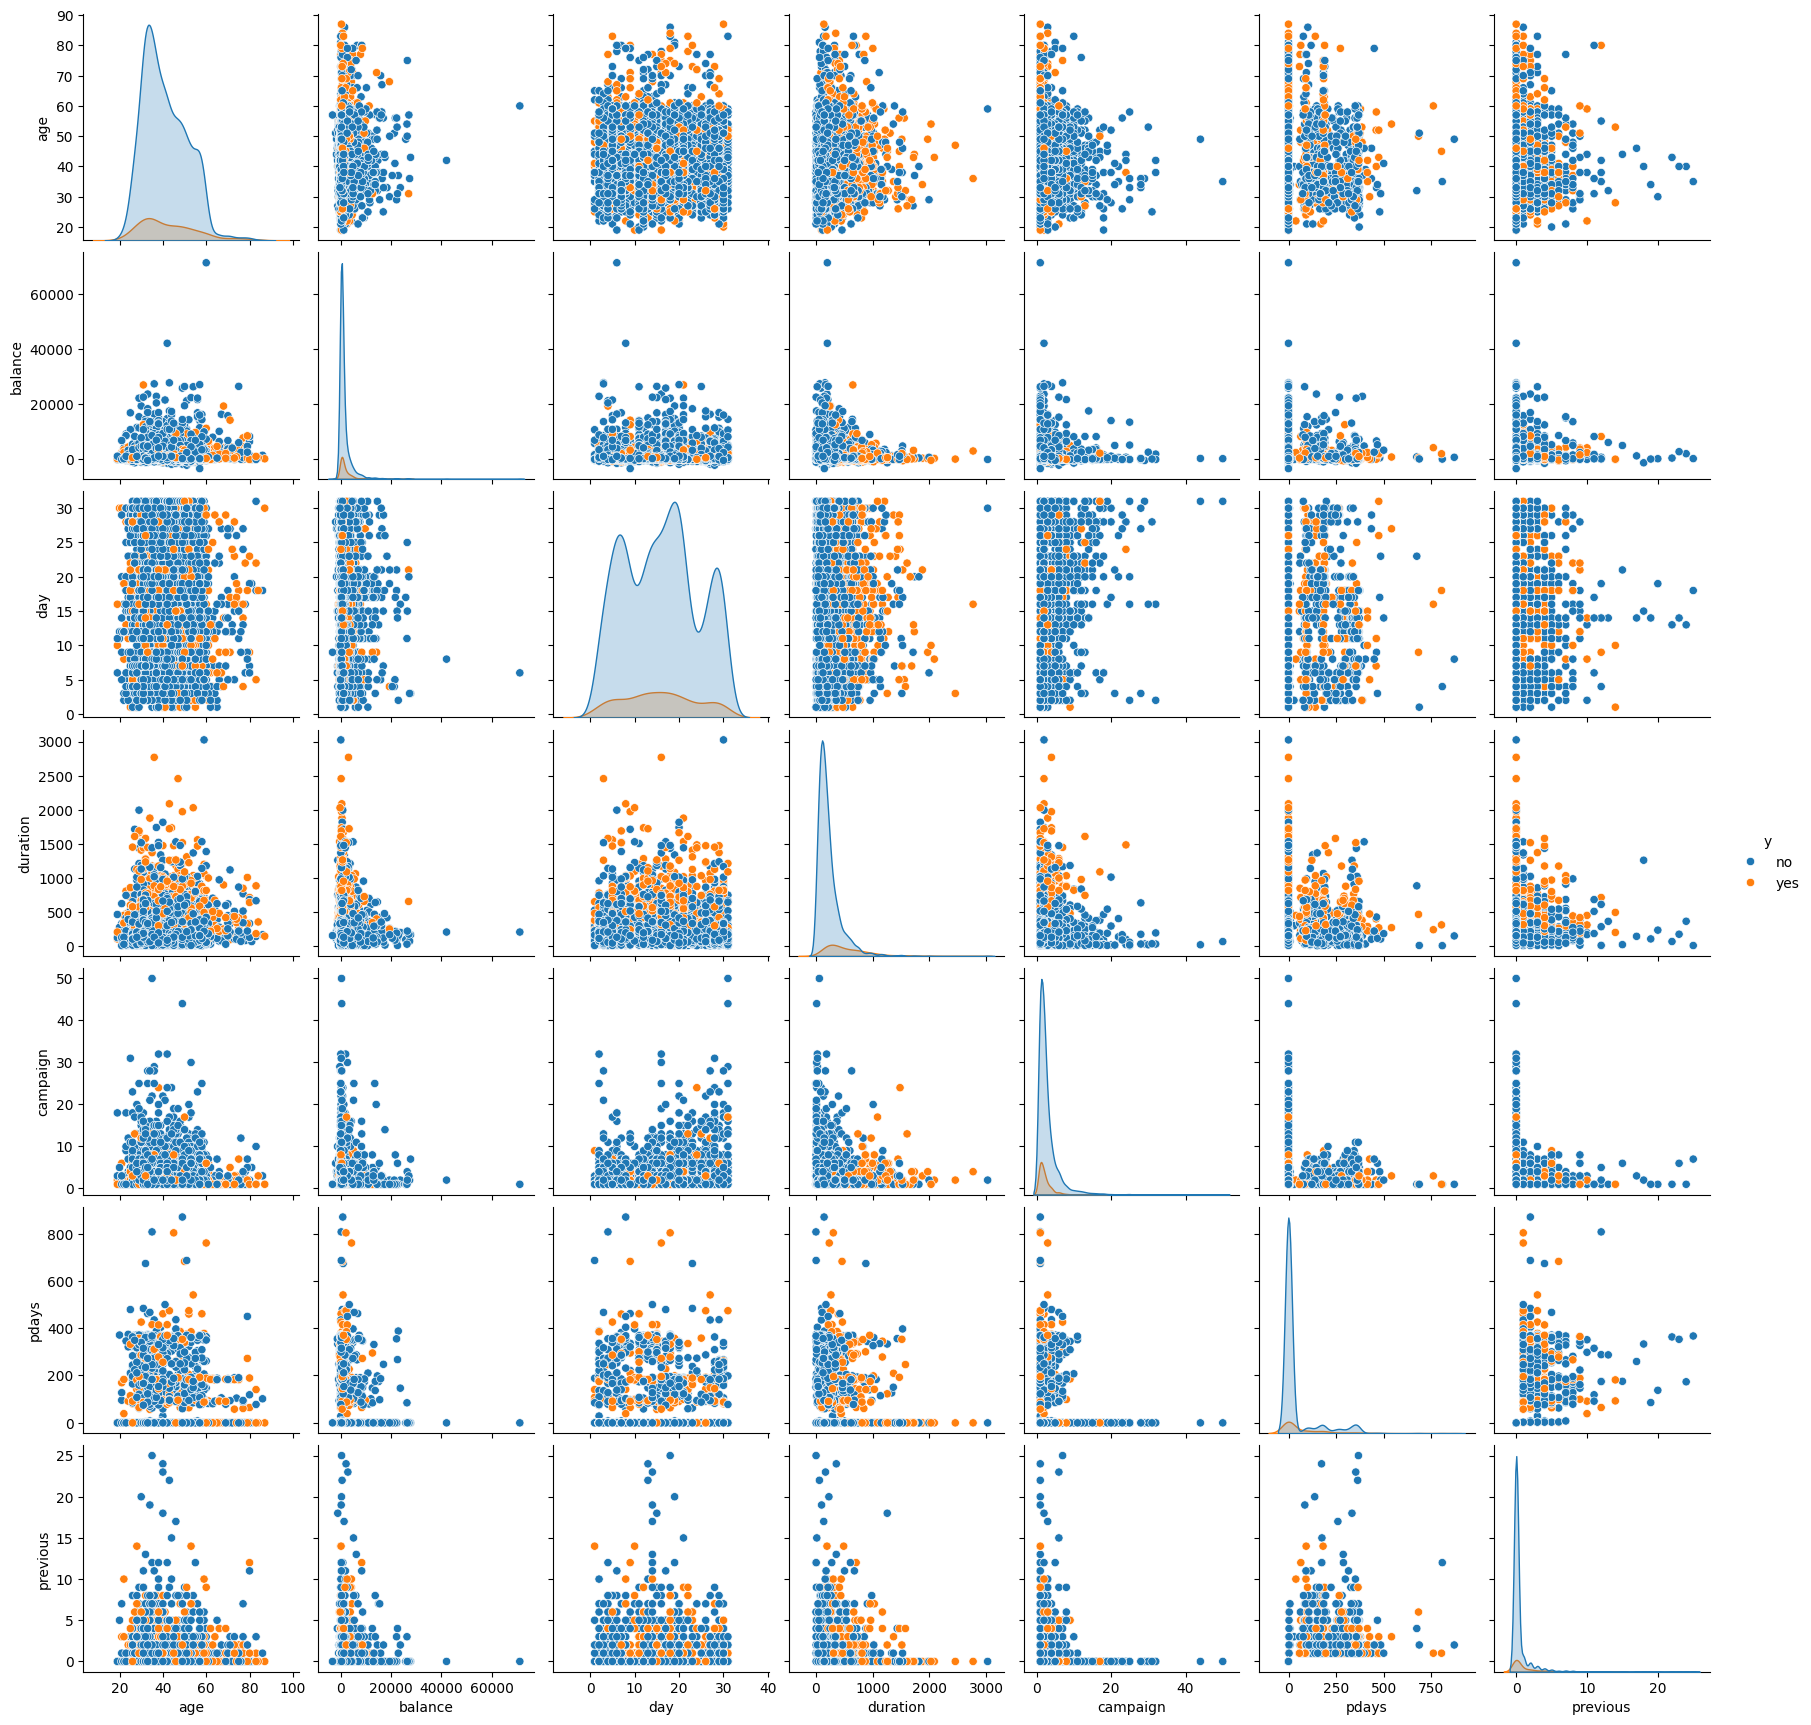

In [14]:
sns.pairplot(df, hue='y')

El gráfico a continuación muestra que algunas características categóricas influyen más en la característica objetivo que otras. Por ejemplo, las personas con la profesión de "management" responden con más frecuencia "sí" al atributo objetivo que las personas con la profesión de "blue-collar". También es evidente que existe un desequilibrio significativo en el atributo objetivo.

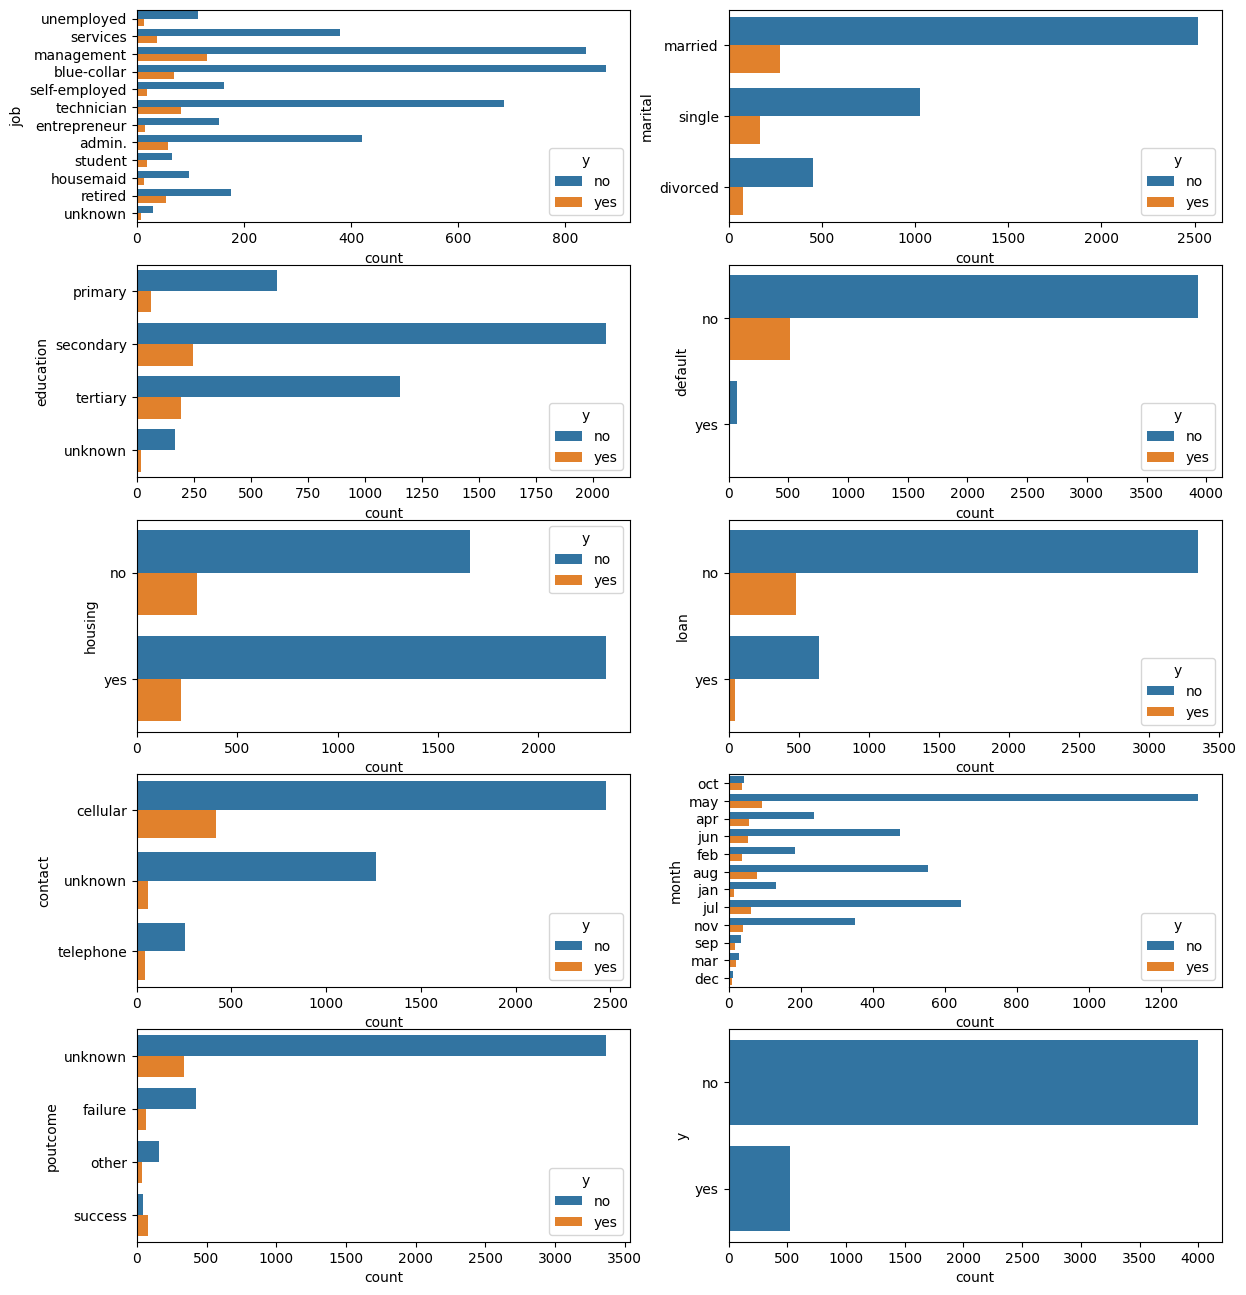

In [ ]:
fig, ax= plt.subplots(nrows=5, ncols=2, figsize= (14,16))
sns.countplot(y='job', hue='y', data=df, ax=ax[0][0])
sns.countplot(y='marital', hue='y', data=df, ax=ax[0][1])
sns.countplot(y='education', hue='y', data=df, ax=ax[1][0])
sns.countplot(y='default', hue='y', data=df, ax=ax[1][1])
sns.countplot(y='housing', hue='y', data=df, ax=ax[2][0])
sns.countplot(y='loan', hue='y', data=df, ax=ax[2][1])
sns.countplot(y='contact', hue='y', data=df, ax=ax[3][0])
sns.countplot(y='month', hue='y', data=df, ax=ax[3][1])
sns.countplot(y='poutcome', hue='y', data=df, ax=ax[4][0])
sns.countplot(y='y', data=df, ax=ax[4][1]);

En el gráfico a continuación se puede observar que tres características numéricas están claramente separadas por la característica objetivo (columnas “duration”, “previous” y “pdays”).

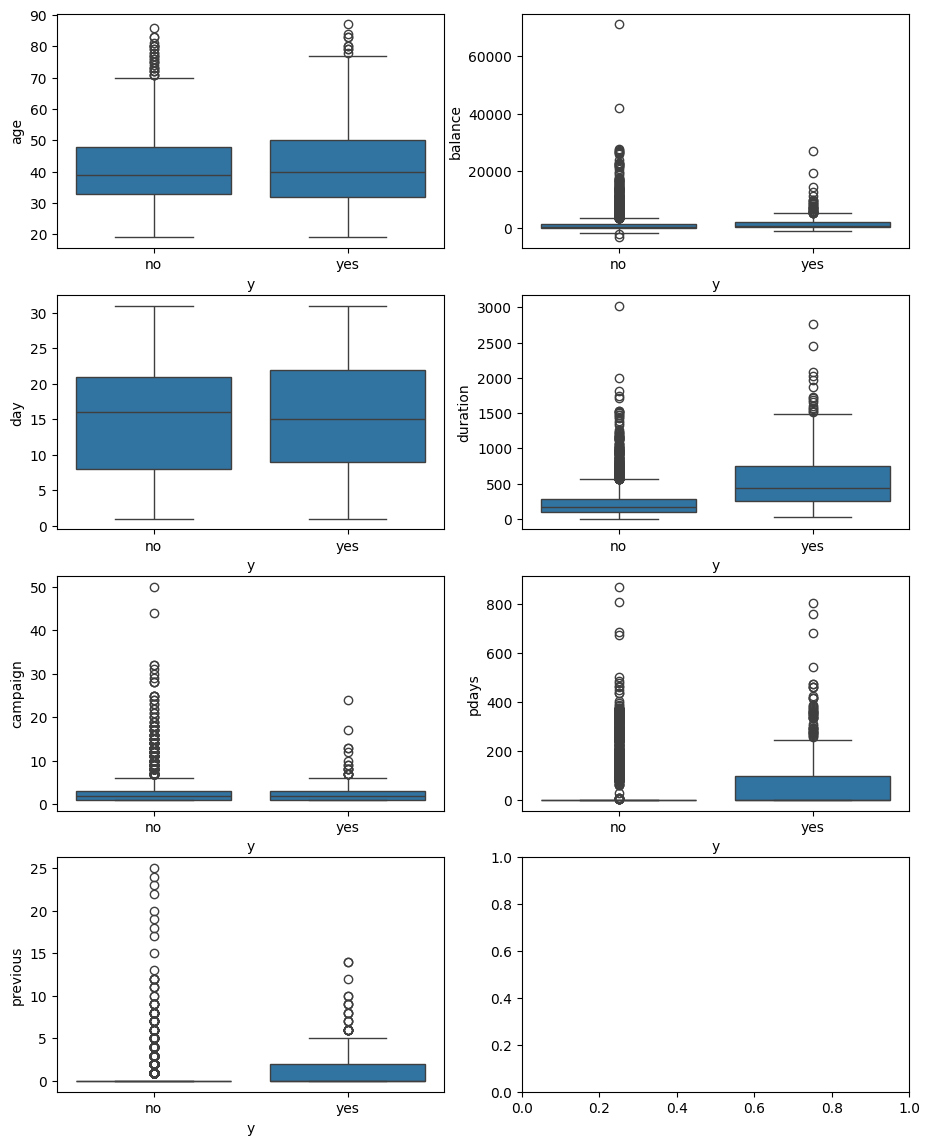

In [17]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(11,14))
sns.boxplot(x='y', y='age', data=df, ax=ax[0][0])
sns.boxplot(x='y', y='balance', data=df, ax=ax[0][1])
sns.boxplot(x='y', y='day', data=df, ax=ax[1][0])
sns.boxplot(x='y', y='duration', data=df, ax=ax[1][1])
sns.boxplot(x='y', y='campaign', data=df, ax=ax[2][0])
sns.boxplot(x='y', y='pdays', data=df, ax=ax[2][1])
sns.boxplot(x='y', y='previous', data=df, ax=ax[3][0]);

In [20]:
df_copy = df.copy()

label_encoder = LabelEncoder()
for col in df_copy.select_dtypes(["object", "category"]):
    df_copy[col] = label_encoder.fit_transform(df_copy[col])

<Axes: >

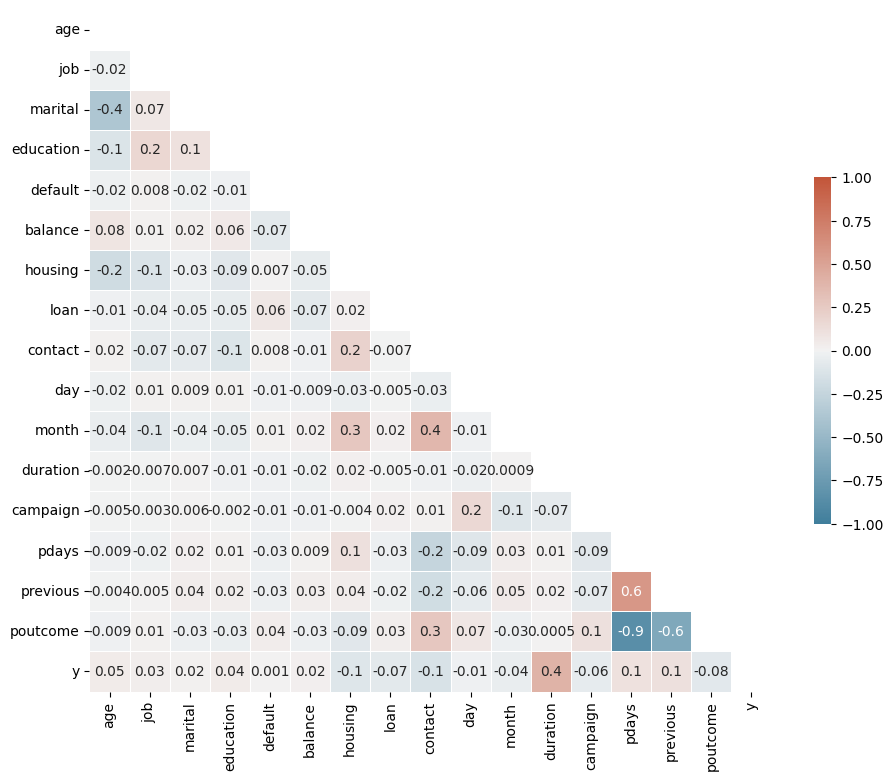

In [21]:
corr = df_copy.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.1g')

## Feature Enginering

In [27]:
X = df_copy.drop(['y'], axis=1)
y = df_copy['y']

### Mutual information

/Users/mau/GitHub/bankmkt_term_deposit_pred/.venv/lib/python3.13/site-packages/sklearn/metrics/cluster/_supervised.py:49: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_label = type_of_target(labels_true)


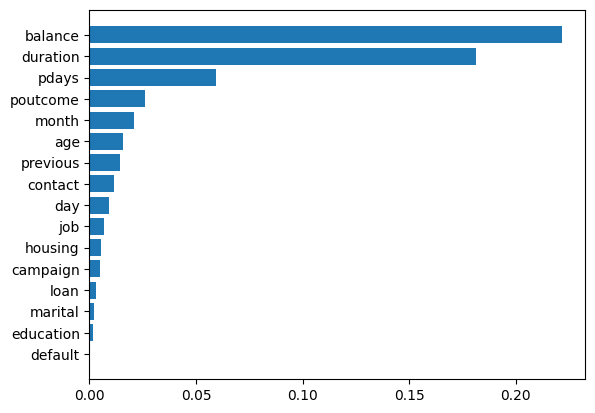

In [28]:
mi_scores = make_mi_scores(X, y)
plot_mi_scores(mi_scores)

## Modelos

Se probarán varios modelos

In [30]:
def score_models(x, y, models: dict, scoring='precision'):

    scores = {}
    
    for name, model in models.items():
        score = score_dataset(x, y, model, scoring)
        scores[name] = score
    
    return scores
        
def score_dataset(x, y, model, scoring='precision'):

    for colname in x.select_dtypes(['category', 'object']):
        x[colname], _ = x[colname].factorize()

    score = cross_val_score(
        model, x, y, cv=5, scoring=scoring,
    )

    score = score.mean()
    return score

In [31]:
models = {
    'RandomForestClassifier': RandomForestClassifier(random_state=RANDOM_STATE),
    'XGBClassifier': XGBClassifier(random_state=RANDOM_STATE),
    'LGBMClassifier': LGBMClassifier(random_state=RANDOM_STATE),
    'CatBoostClassifier': CatBoostClassifier(verbose=False, random_state=RANDOM_STATE),
}

In [32]:
score_models(X, y, models)

[LightGBM] [Info] Number of positive: 416, number of negative: 3200
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 891
[LightGBM] [Info] Number of data points in the train set: 3616, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.115044 -> initscore=-2.040221
[LightGBM] [Info] Start training from score -2.040221
[LightGBM] [Info] Number of positive: 417, number of negative: 3200
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 904
[LightGBM] [Info] Number of data points in the train set: 3617, number of used features: 16
[LightGBM] [Info] [binary:Bo

{'RandomForestClassifier': np.float64(0.6008638719758517),
 'XGBClassifier': np.float64(0.5659917041064582),
 'LGBMClassifier': np.float64(0.5742320597687598),
 'CatBoostClassifier': np.float64(0.6186668751078144)}

In [34]:
score_models(X[['balance', 'pdays', 'poutcome']], y, models)

[LightGBM] [Info] Number of positive: 416, number of negative: 3200
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 460
[LightGBM] [Info] Number of data points in the train set: 3616, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.115044 -> initscore=-2.040221
[LightGBM] [Info] Start training from score -2.040221
[LightGBM] [Info] Number of positive: 417, number of negative: 3200
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000148 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 472
[LightGBM] [Info] Number of data points in the train set: 3617, number of used features: 3
[LightGBM] [Info] [binary:Boos

{'RandomForestClassifier': np.float64(0.23293913929208046),
 'XGBClassifier': np.float64(0.5528943278943279),
 'LGBMClassifier': np.float64(0.5528038235401973),
 'CatBoostClassifier': np.float64(0.5957902001380262)}